# Setup of Colab, mlflow, importing libraries

# Import Libraries

In [ ]:
import os, json, pickle, shutil
import cv2
import json
import gc
from PIL import Image
import datetime
import numpy as np
import matplotlib.pyplot as plt

import requests
from tqdm import tqdm
from pathlib import Path

# import keras
# from keras import layers, models, backend as K
# from keras.applications import VGG16
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
# from keras.optimizers.schedules import ExponentialDecay
# from keras.metrics import AUC
# from keras.optimizers import Adam #SparseCategoricalAccuracy
# from keras.metrics import IoU, Mean, SparseCategoricalAccuracy
# from keras.losses import SparseCategoricalCrossentropy

import tensorflow as tf
from transformers import TFSegformerForSemanticSegmentation, SegformerForSemanticSegmentation, SegformerImageProcessor
from transformers import SegformerConfig

In [ ]:
import tensorflow.keras as tf_keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam #SparseCategoricalAccuracy
from tensorflow.keras.metrics import IoU, Mean, SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
import mlflow
from pyngrok import ngrok

# Data Preparation

## Convert Images and Masks to TFRecord format



1. normalize images (rescale between 0 and 1)
2. resize if needed
3. distort to augment
4. Augment more professio
5. Plot images

### Create paths to training and validation sets (before converting to TFRecords)

In [ ]:
def get_cityscapes_file_paths(img_root_dir, label_root_dir, subset):
    img_paths = []
    label_paths = []
    color_labels = []
    subset_dir = os.path.join(img_root_dir, subset)

    for city in os.listdir(subset_dir):
        city_img_dir = os.path.join(subset_dir, city)
        city_label_dir = os.path.join(label_root_dir, subset, city)
        city_color_label_dir = os.path.join(label_root_dir, subset, city)
        for img_file in os.listdir(city_img_dir):
            if img_file.endswith('_leftImg8bit.png'):
                img_path = os.path.join(city_img_dir, img_file)

                label_file = img_file.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                label_path = os.path.join(city_label_dir, label_file)

                color_file = img_file.replace('_leftImg8bit.png', '_gtFine_color.png')
                color_path = os.path.join(city_color_label_dir, color_file)


                if os.path.exists(label_path):
                    img_paths.append(img_path)
                    label_paths.append(label_path)
                    color_labels.append(color_path)
                else:
                    print(f"Warning: Label file {label_path} does not exist.")

    return img_paths, label_paths, color_labels

# paths to images and their masks/images:
img_root_dir = 'data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/'
label_root_dir = 'data/P8_Cityscapes_gtFine_trainvaltest/gtFine/'


train_img_paths, train_label_paths, train_color_labels = get_cityscapes_file_paths(img_root_dir, label_root_dir, 'train')
val_img_paths, val_label_paths, val_color_labels = get_cityscapes_file_paths(img_root_dir, label_root_dir, 'val')

print(f"Number of training images: {len(train_img_paths)}")
print(f"Number of validation images: {len(val_img_paths)}")
print(f'Number of validation imabes: {len(val_color_labels)}')

Number of training images: 2975
Number of validation images: 500
Number of validation imabes: 500


### Labels - map thirty categories in mask images to eight (Before TFRecords)

In [ ]:
# Original 30 classes
original_classes = [
    'road', 'sidewalk', 'parking', 'rail track', 'person', 'rider', 'car', 'truck', 'bus', 'on rails',
    'motorcycle', 'bicycle', 'caravan', 'trailer', 'building', 'wall', 'fence', 'guard rail', 'bridge',
    'tunnel', 'pole', 'pole group', 'traffic sign', 'traffic light', 'vegetation', 'terrain', 'sky',
    'ground', 'dynamic', 'static'
]


# Mapping to 8 major groups
class_mapping = {
    'road': 'flat', 'sidewalk': 'flat', 'parking': 'flat', 'rail track': 'flat',
    'person': 'human', 'rider': 'human',
    'car': 'vehicle', 'truck': 'vehicle', 'bus': 'vehicle', 'on rails': 'vehicle',
    'motorcycle': 'vehicle', 'bicycle': 'vehicle', 'caravan': 'vehicle', 'trailer': 'vehicle',
    'building': 'construction', 'wall': 'construction', 'fence': 'construction', 'guard rail': 'construction',
    'bridge': 'construction', 'tunnel': 'construction',
    'pole': 'object', 'pole group': 'object', 'traffic sign': 'object', 'traffic light': 'object',
    'vegetation': 'nature', 'terrain': 'nature',
    'sky': 'sky',
    'ground': 'void', 'dynamic': 'void', 'static': 'void'
}

# New labels for the 8 major groups
new_labels = {
    'flat': 0, 'human': 1, 'vehicle': 2, 'construction': 3, 'object': 4, 'nature': 5, 'sky': 6, 'void': 7
}

In [ ]:
def map_labels_tf(label_image, original_classes, class_mapping, new_labels):
    label_image = tf.squeeze(label_image)
    label_image_shape = tf.shape(label_image)
    mapped_label_image = tf.zeros_like(label_image, dtype=tf.uint8)
    for original_class, new_class in class_mapping.items():
        try:
            original_class_index = tf.cast(original_classes.index(original_class), tf.uint8)
            new_class_index = tf.cast(new_labels[new_class], tf.uint8)
            mask = tf.equal(label_image, original_class_index)
            fill_val = tf.fill(label_image_shape, tf.cast(new_class_index, tf.uint8))  # tf.shape defaults on int32
            mapped_label_image = tf.where(mask, fill_val, mapped_label_image)
        except Exception as e:
            tf.print(f"""\n
            1. label_image shape:    {label_image.shape}\n
            2. mapped_label_image shape: {mapped_label_image.shape}\n
            3. label_image.shape:    {label_image.shape}\n
            4. new_class:            {new_class}\n
            """)
            raise e
    label = tf.expand_dims(mapped_label_image, axis=-1)  # Add back the last dimension
    label = tf.image.convert_image_dtype(label, tf.uint8)
    return label

### Helper Functions to convert images to tfrecords dataset

In [ ]:
def read_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def read_label(file_path):
    label = tf.io.read_file(file_path)
    label = tf.image.decode_image(label, channels=1)
    label = tf.image.convert_image_dtype(label, tf.uint8)
    label = map_labels_tf(label, original_classes, class_mapping, new_labels)
    return label

def serialize_tensor(tensor):
    return tf.io.serialize_tensor(tensor)

def serialize_example(image_tensor, label_tensor):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialize_tensor(image_tensor).numpy()])),
        'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialize_tensor(label_tensor).numpy()]))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

### Convert all images in tfrecord format

In [ ]:
def process_and_write_images_labels_in_batches(image_paths,
                                               label_paths,
                                               output_tfrecord_path,
                                               batch_size=32,
                                               num_parallel_calls=tf.data.experimental.AUTOTUNE):

    # Create datasets from the list of file paths
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(label_paths)

    # Map file paths to image and label tensors, with parallel processing
    image_dataset = image_dataset.map(read_image, num_parallel_calls=num_parallel_calls)
    label_dataset = label_dataset.map(read_label, num_parallel_calls=num_parallel_calls)

    # Zip the datasets together
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Create a TFRecord writer
    with tf.io.TFRecordWriter(output_tfrecord_path) as writer:
        # Iterate over the batches of images and labels
        for batch in tqdm(dataset):
            image_batch, label_batch = batch
            for image, label in zip(image_batch, label_batch):
                # Serialize each image and label, and write to the TFRecord file
                serialized_example = serialize_example(image, label)
                writer.write(serialized_example)

In [ ]:
process_and_write_images_labels_in_batches(train_img_paths,
                                           train_label_paths,
                                           "train_images_and_labels_v3.tfrecord",
                                           batch_size=48,
                                           num_parallel_calls=tf.data.experimental.AUTOTUNE)

100%|██████████| 62/62 [07:57<00:00,  7.71s/it]


In [ ]:
process_and_write_images_labels_in_batches(val_img_paths,
                                            val_label_paths,
                                            "valid_images_and_labels_v3.tfrecord",
                                            batch_size=48,
                                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

100%|██████████| 11/11 [01:42<00:00,  9.28s/it]


## Loading Images from TfRecord file


In [ ]:
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string)
    }

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.parse_tensor(parsed_example['image'], out_type=tf.float32)
    label = tf.io.parse_tensor(parsed_example['label'], out_type=tf.uint8)

    # Ensure shapes are defined
    image = tf.ensure_shape(image, [None, None, 3])
    label = tf.ensure_shape(label, [None, None, 1])
    return image, label

In [ ]:
def augment_image_and_label(image, label, augment_prob=0.3):
    def augment():

        # Generate a random seed
        seed = tf.random.uniform([2], maxval=64, dtype=tf.int32)

        # Apply augmentations with the seed
        if tf.random.uniform([], minval=0, maxval=1.0, dtype=tf.float32) > augment_prob:
            image_in = tf.image.stateless_random_flip_left_right(image, seed=seed)
            label_in = tf.image.stateless_random_flip_left_right(label, seed=seed)
        else:
            image_in = image
            label_in = label

        if tf.random.uniform([], minval=0, maxval=1.0, dtype=tf.float32) > augment_prob:
            image_in = tf.image.stateless_random_flip_up_down(image_in, seed=seed)
            label_in = tf.image.stateless_random_flip_up_down(label_in, seed=seed)

        if tf.random.uniform([], minval=0, maxval=1.0, dtype=tf.float32) > augment_prob:
            image_in = tf.image.stateless_random_brightness(image_in, max_delta=0.2, seed=seed)
            image_in = tf.image.stateless_random_contrast(image_in, lower=0.8, upper=1.2, seed=seed)

        return image_in, label_in

    def no_augment():
        return image, label

    # Use a stateless random number for consistency
    random_number = tf.random.uniform([], minval=0, maxval=1.0, dtype=tf.float32)
    image, label = tf.cond(random_number < augment_prob, augment, no_augment)

    image = tf.image.convert_image_dtype(image, tf.float32)
    # Clip the values to ensure they are within [0, 1]
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    label = tf.image.convert_image_dtype(label, tf.uint8)
    return image, label

In [ ]:
def normalize(input_image, input_mask):
    mean = tf.constant([0.485, 0.456, 0.406])
    std = tf.constant([0.229, 0.224, 0.225])

    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, K.epsilon())

    # Clip the values to ensure they are within [0, 1]
    input_image = tf.clip_by_value(input_image, clip_value_min=0.0, clip_value_max=1.0)
    return input_image, input_mask

# Mini U-net combined with VGG16

## (1) Define paths

In [ ]:
model_name = f'unet'
# Logs for mlflow
drive_mlflow_logs = f"/content/drive/MyDrive/oc/8th_project/experiments/{model_name}/mlruns"
local_mlflow_logs =f"/content/mlruns"

# Logs for Tensorflow Tensorboard
drive_tbrd_logs = f"/content/drive/MyDrive/oc/8th_project/experiments/{model_name}/tbrd_logs/fit"
local_tbrd_logs = f"/content/tbr_logs/fit"

# checkpoints
drive_ckpts_logs = f"/content/drive/MyDrive/oc/8th_project/experiments/{model_name}/checkpoints"
local_ckpts_logs = f"/content/local_checkpoints"

# model logging
model_logs = f"experiments/segformer/models"

# datasets
drive_train_dataset = f"/content/drive/MyDrive/oc/8th_project/data/train_data"
drive_valid_dataset = f"/content/drive/MyDrive/oc/8th_project/data/valid_data"

# Create the drive directories if it they don't exist
os.makedirs(drive_mlflow_logs, exist_ok=True)
os.makedirs(drive_tbrd_logs, exist_ok=True)
os.makedirs(drive_ckpts_logs, exist_ok=True)
os.makedirs(model_logs, exist_ok=True)
os.makedirs(local_mlflow_logs, exist_ok=True)
os.makedirs(local_tbrd_logs, exist_ok=True)
os.makedirs(local_ckpts_logs, exist_ok=True)

# datasets
drive_train_dataset = f"/content/drive/MyDrive/oc/8th_project/train_data"
drive_valid_dataset = f"/content/drive/MyDrive/oc/8th_project/valid_data"

# local directory for datasets
local_datasets = f"/content/local_datasets"
os.makedirs(local_datasets, exist_ok=True)

## (2) Prepare and load the data for UNet

In [ ]:
def load_dataset_unet(tfrecord_file, batch_size=2):
    # Create a dataset from the TFRecord file
    dataset = tf.data.TFRecordDataset(tfrecord_file)

    # Parse the serialized examples
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # dataset = dataset.map(lambda x, y: tf.py_function(augment, [x, y], [tf.float32, tf.uint8]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(augment_image_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
# train_tfrecord_file = "/content/drive/MyDrive/oc/8th_project/data/train/train_images_and_labels_v3.tfrecord"
# valid_tfrecord_file = "/content/drive/MyDrive/oc/8th_project/data/valid/valid_images_and_labels_v3.tfrecord"

train_tfrecord_file = "/content/local_datasets/train_images_and_labels_v3.tfrecord"
valid_tfrecord_file = "/content/local_datasets/valid_images_and_labels_v3.tfrecord"

train_dataset = load_dataset_unet(train_tfrecord_file, batch_size=6)
valid_dataset = load_dataset_unet(valid_tfrecord_file, batch_size=2)

In [ ]:
def plot_image_unet(image, segmentation, image_title='Original Image'):

    # Convert the image to uint8 if it's not already
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Ensure image is in the range [0, 1] and convert to uint8
    image = np.array(image)
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
    image = (image * 255).astype(np.uint8)

    # Convert segmentation to uint8
    segmentation = (segmentation.numpy()).astype(np.uint8)
    segmentation = np.squeeze(segmentation)
    segmentation = Image.fromarray(segmentation)

    # Convert to PIL Image
    image = Image.fromarray(image)

    # Plotting the image and its segmentation
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title(image_title)
    axes[0].axis('off')

    # Segmentation mask
    axes[1].imshow(image)
    axes[1].imshow(segmentation, cmap='jet', alpha=0.5)  # Overlaying segmentation with some transparency
    axes[1].set_title('Segmentation Applied')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

(6, 1024, 2048, 3)
(6, 1024, 2048, 1)
(1024, 2048, 3)
1.0
0.0


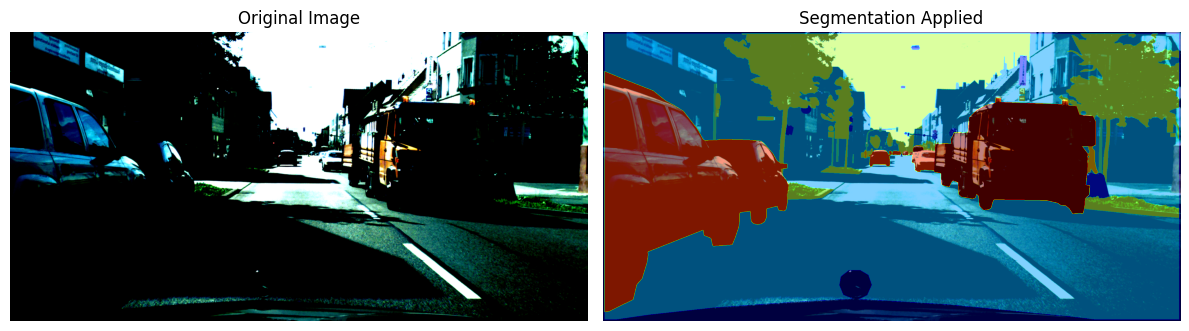

(6, 1024, 2048, 3)
(6, 1024, 2048, 1)
(1024, 2048, 3)
1.0
0.0


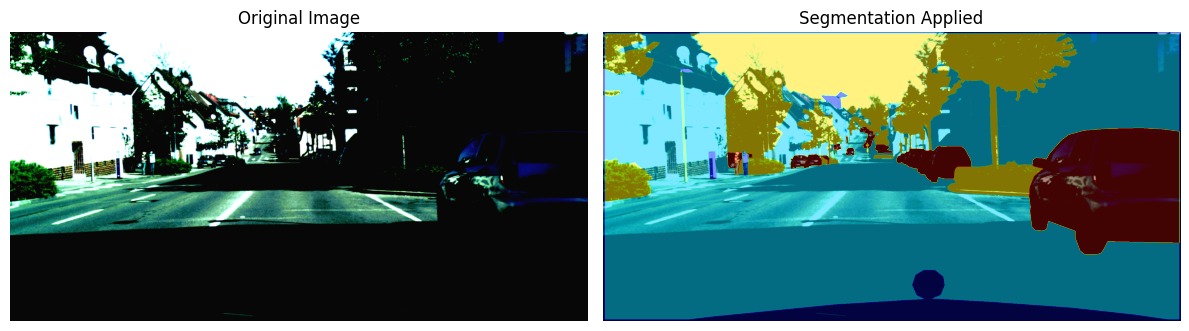

In [ ]:
for images, labels in train_dataset.take(2):
    print(images.shape)
    print(labels.shape)
    print(images[0].numpy()[..., ::-1].shape)
    print(images.numpy().max())
    print(images.numpy().min())

    plot_image_unet(images[0], labels[0])

## (3) Build Model with Keras

In [ ]:
tf.keras.backend.clear_session()

### 3.1. Define Metrics (custom and builtin)

In [ ]:
# Define custom metrics

# Custom Dice Coefficient
def dice_coefficient(y_true, y_pred):
    # One-hot encode the true labels if necessary (assuming y_true is not already one-hot encoded)
    y_true_f = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Flatten the tensors
    y_true_f = tf.reshape(y_true_f, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Calculate the intersection
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the Dice coefficient
    return (2. * intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1)

# Custom IoU (Intersection over Union)
def iou(y_true, y_pred):

    # One-hot encode the true labels if necessary (assuming y_true is not already one-hot encoded)
    y_true_f = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Flatten the tensors
    y_true_f = tf.reshape(y_true_f, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Calculate the intersection
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the union
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    # Calculate the IoU
    return (intersection + 1) / (union + 1)

In [ ]:
# Combine custom and builtin metrics for Keras model.fit method
metrics = [dice_coefficient, iou, 'accuracy']

### 3.2 Define Callbacks

In [ ]:
class PlotResultsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, plot_interval = 10):
        super(PlotResultsCallback, self).__init__()
        self.validation_data = validation_data
        self.plot_interval = plot_interval

    def on_epoch_end(self, epoch, logs=None):
        # Plot every 'plot_interval' epochs
        if epoch % self.plot_interval == 0:
            # Get a batch of validation data
            val_images, val_masks = next(iter(self.validation_data))

            # Predict the masks
            predictions = self.model(val_images, training=False)
            predicted_masks = tf.argmax(predictions, axis=-1)

            # Plot the results
            # for i in range(self.num_samples):
            plt.figure(figsize=(12, 4))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(val_images[0])
            plt.title("Image")
            plt.axis("off")

            # True mask
            plt.subplot(1, 3, 2)
            plt.imshow(val_images[0])
            plt.imshow(tf.squeeze(val_masks[0]),cmap='jet', alpha=0.5)
            plt.title("True Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(val_images[0])
            plt.imshow(predicted_masks[0], cmap='jet', alpha=0.5)
            plt.title("Predicted Mask")
            plt.axis("off")
            plt.show()

plot_callback = PlotResultsCallback(validation_data=valid_dataset)

In [ ]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # You can also monitor 'val_accuracy'
    factor=0.5,  # Factor by which the learning rate will be reduced
    patience=10,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,  # Verbosity mode, 1 = print messages
    mode='auto',  # Mode: 'auto', 'min', or 'max'
    min_delta=0.0001,  # Threshold for measuring the new optimum
    cooldown=0,  # Number of epochs to wait before resuming normal operation after lr has been reduced
    min_lr=0.0000001  # Lower bound on the learning rate
)

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

# Define model checkpoint callback to save best 3 models
checkpoint_path = "experiments/unet/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    verbose=1
)

In [ ]:
# Create a list of callbacks
callbacks = [early_stop, model_checkpoint, reduce_lr, plot_callback]

### 3.3 Define Model and Optimizer

In [ ]:
# Define the U-Net model with VGG16 encoder
def unet_with_vgg16_encoder(input_shape, num_classes):
    inputs = keras.Input(input_shape)

    # Load VGG16 with pre-trained weights and exclude the top fully connected layers
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Freeze the VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = False

    # Extract layers for skip connections
    skip1 = vgg16.get_layer("block1_conv2").output  # 64 filters
    skip2 = vgg16.get_layer("block2_conv2").output  # 128 filters
    skip3 = vgg16.get_layer("block3_conv3").output  # 256 filters
    skip4 = vgg16.get_layer("block4_conv3").output  # 512 filters

    # Bottleneck (last layer of VGG16)
    bottleneck = vgg16.get_layer("block5_conv3").output  # 512 filters

    # Decoder with dropout
    d1 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    d1 = layers.concatenate([d1, skip4])
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    d1 = layers.Dropout(0.5)(d1)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)

    d2 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d1)
    d2 = layers.concatenate([d2, skip3])
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    d2 = layers.Dropout(0.5)(d2)
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)

    d3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d2)
    d3 = layers.concatenate([d3, skip2])
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    d3 = layers.Dropout(0.5)(d3)
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d3)

    d4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d3)
    d4 = layers.concatenate([d4, skip1])
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    d4 = layers.Dropout(0.5)(d4)
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

## (4) Initialize, train, and save the model

### 4.1. initialize the model

In [ ]:
keras.backend.clear_session()

In [ ]:
# Example usage
input_shape = (1024, 2048, 3)  # Input shape for Cityscapes dataset
num_classes = 8  # Number of major groups/classes in mask
model = unet_with_vgg16_encoder(input_shape, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1024, 2048, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 1024, 2048, 64) │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 1024, 2048, 64) │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 512, 1024, 64)  │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 512, 1024, 128) │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 512, 1024, 128) │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 256, 512, 128)  │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 256, 512, 256)  │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 256, 512, 256)  │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 256, 512, 256)  │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 128, 256, 256)  │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 128, 256, 512)  │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 128, 256, 512)  │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 128, 256, 512)  │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 64, 128, 512)   │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 64, 128, 512)   │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 64, 128, 512)   │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 25,855,112 (98.63 MB)

 Trainable params: 11,140,424 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model with the custom metrics
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=metrics)

### 4.2. Train the model

Epoch 1/250
    495/Unknown 672s 874ms/step - accuracy: 0.6253 - dice_coefficient: 0.4693 - iou: 0.3107 - loss: 1.2658

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 0.94334, saving model to experiments/unet/checkpoints/weights.01-0.94.keras


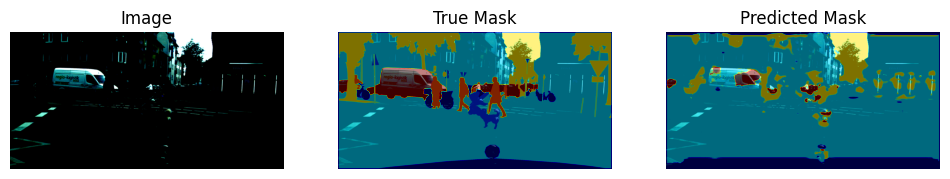

495/495 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.6254 - dice_coefficient: 0.4694 - iou: 0.3108 - loss: 1.2654 - val_accuracy: 0.7153 - val_dice_coefficient: 0.5329 - val_iou: 0.3641 - val_loss: 0.9433 - learning_rate: 1.0000e-04
Epoch 2/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.7239 - dice_coefficient: 0.5872 - iou: 0.4176 - loss: 0.8955
Epoch 2: val_loss improved from 0.94334 to 0.87138, saving model to experiments/unet/checkpoints/weights.02-0.87.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.7239 - dice_coefficient: 0.5873 - iou: 0.4177 - loss: 0.8955 - val_accuracy: 0.7289 - val_dice_coefficient: 0.5601 - val_iou: 0.3900 - val_loss: 0.8714 - learning_rate: 1.0000e-04
Epoch 3/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.7353 - dice_coefficient: 0.6050 - iou: 0.4357 - loss: 0.8514
Epoch 3: val_loss improved from 0.87138 to 0.85017, saving model to experiments/unet/checkpoints/weights.03-0.85.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 5

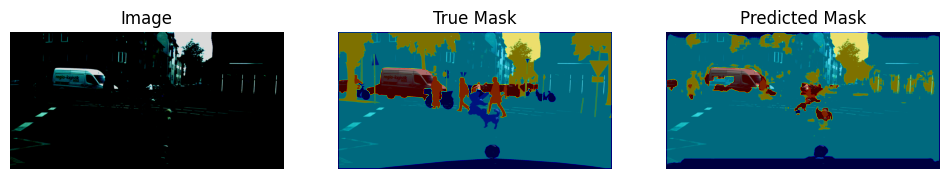

495/495 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.7609 - dice_coefficient: 0.6446 - iou: 0.4774 - loss: 0.7609 - val_accuracy: 0.7548 - val_dice_coefficient: 0.5969 - val_iou: 0.4265 - val_loss: 0.7900 - learning_rate: 1.0000e-04
Epoch 12/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.7615 - dice_coefficient: 0.6455 - iou: 0.4784 - loss: 0.7594
Epoch 12: val_loss improved from 0.78999 to 0.78016, saving model to experiments/unet/checkpoints/weights.12-0.78.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.7615 - dice_coefficient: 0.6455 - iou: 0.4784 - loss: 0.7594 - val_accuracy: 0.7579 - val_dice_coefficient: 0.5984 - val_iou: 0.4282 - val_loss: 0.7802 - learning_rate: 1.0000e-04
Epoch 13/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.7628 - dice_coefficient: 0.6477 - iou: 0.4807 - loss: 0.7535
Epoch 13: val_loss did not improve from 0.78016
495/495 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.7628 - dice_coefficient: 0.6477 - iou: 0.4

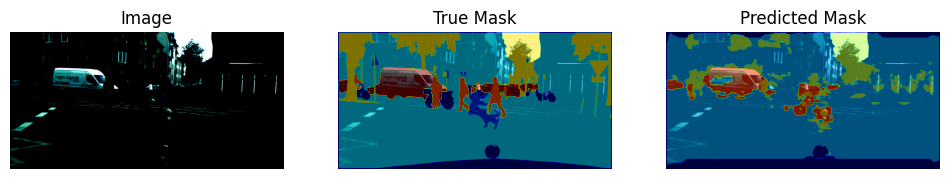

495/495 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.7704 - dice_coefficient: 0.6588 - iou: 0.4929 - loss: 0.7280 - val_accuracy: 0.7641 - val_dice_coefficient: 0.6121 - val_iou: 0.4421 - val_loss: 0.7571 - learning_rate: 1.0000e-04
Epoch 22/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.7712 - dice_coefficient: 0.6602 - iou: 0.4943 - loss: 0.7245
Epoch 22: val_loss did not improve from 0.75713
495/495 ━━━━━━━━━━━━━━━━━━━━ 504s 1s/step - accuracy: 0.7712 - dice_coefficient: 0.6602 - iou: 0.4944 - loss: 0.7244 - val_accuracy: 0.7630 - val_dice_coefficient: 0.6139 - val_iou: 0.4441 - val_loss: 0.7615 - learning_rate: 1.0000e-04
Epoch 23/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7704 - dice_coefficient: 0.6595 - iou: 0.4936 - loss: 0.7260
Epoch 23: val_loss did not improve from 0.75713
495/495 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.7705 - dice_coefficient: 0.6595 - iou: 0.4936 - loss: 0.7259 - val_accuracy: 0.7647 - val_dice_coefficient: 0.6157

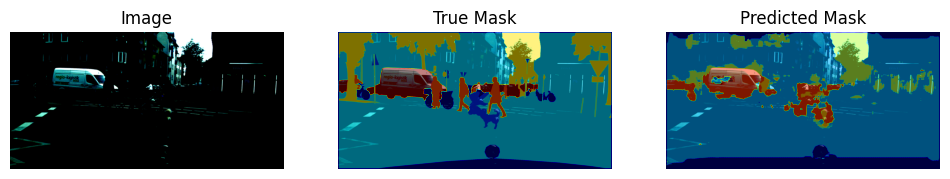

495/495 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.7771 - dice_coefficient: 0.6694 - iou: 0.5048 - loss: 0.7030 - val_accuracy: 0.7651 - val_dice_coefficient: 0.6213 - val_iou: 0.4518 - val_loss: 0.7383 - learning_rate: 1.0000e-04
Epoch 32/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.7771 - dice_coefficient: 0.6691 - iou: 0.5045 - loss: 0.7028
Epoch 32: val_loss did not improve from 0.73627
495/495 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.7771 - dice_coefficient: 0.6692 - iou: 0.5045 - loss: 0.7027 - val_accuracy: 0.7669 - val_dice_coefficient: 0.6255 - val_iou: 0.4564 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 33/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.7765 - dice_coefficient: 0.6683 - iou: 0.5035 - loss: 0.7060
Epoch 33: val_loss improved from 0.73627 to 0.73298, saving model to experiments/unet/checkpoints/weights.33-0.73.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.7765 - dice_coefficient: 0.6683 - iou: 0.5

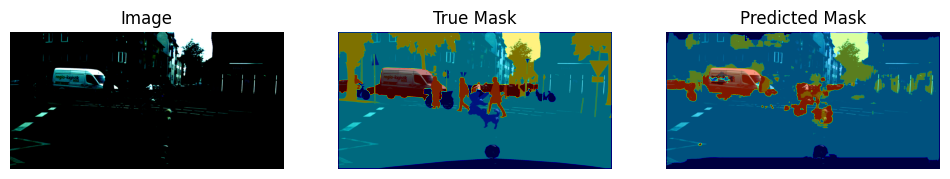

495/495 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.7825 - dice_coefficient: 0.6770 - iou: 0.5133 - loss: 0.6858 - val_accuracy: 0.7688 - val_dice_coefficient: 0.6346 - val_iou: 0.4661 - val_loss: 0.7212 - learning_rate: 1.0000e-04
Epoch 42/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.7822 - dice_coefficient: 0.6769 - iou: 0.5132 - loss: 0.6859
Epoch 42: val_loss did not improve from 0.72122
495/495 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.7822 - dice_coefficient: 0.6770 - iou: 0.5133 - loss: 0.6859 - val_accuracy: 0.7684 - val_dice_coefficient: 0.6374 - val_iou: 0.4691 - val_loss: 0.7234 - learning_rate: 1.0000e-04
Epoch 43/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7824 - dice_coefficient: 0.6773 - iou: 0.5137 - loss: 0.6846
Epoch 43: val_loss did not improve from 0.72122
495/495 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.7825 - dice_coefficient: 0.6773 - iou: 0.5138 - loss: 0.6845 - val_accuracy: 0.7694 - val_dice_coefficient: 0.6396

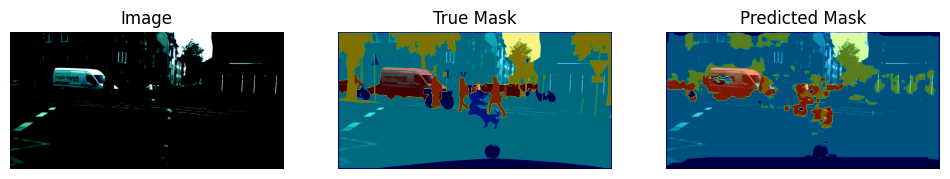

495/495 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.7844 - dice_coefficient: 0.6804 - iou: 0.5172 - loss: 0.6774 - val_accuracy: 0.7698 - val_dice_coefficient: 0.6426 - val_iou: 0.4747 - val_loss: 0.7201 - learning_rate: 1.0000e-04
Epoch 52/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.7853 - dice_coefficient: 0.6821 - iou: 0.5192 - loss: 0.6729
Epoch 52: val_loss did not improve from 0.72014
495/495 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.7854 - dice_coefficient: 0.6822 - iou: 0.5193 - loss: 0.6729 - val_accuracy: 0.7682 - val_dice_coefficient: 0.6334 - val_iou: 0.4648 - val_loss: 0.7261 - learning_rate: 1.0000e-04
Epoch 53/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.7861 - dice_coefficient: 0.6822 - iou: 0.5193 - loss: 0.6740
Epoch 53: val_loss did not improve from 0.72014
495/495 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.7861 - dice_coefficient: 0.6822 - iou: 0.5193 - loss: 0.6739 - val_accuracy: 0.7701 - val_dice_coefficient: 0.6360

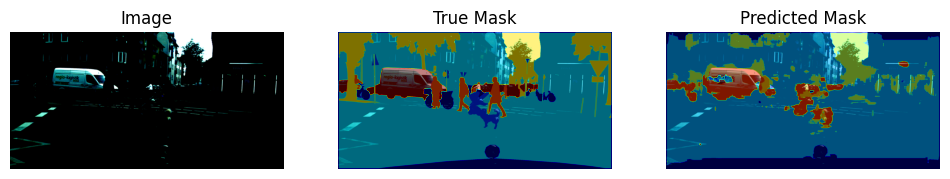

495/495 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.7885 - dice_coefficient: 0.6864 - iou: 0.5241 - loss: 0.6632 - val_accuracy: 0.7719 - val_dice_coefficient: 0.6399 - val_iou: 0.4718 - val_loss: 0.7152 - learning_rate: 1.0000e-04
Epoch 62/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.7889 - dice_coefficient: 0.6870 - iou: 0.5248 - loss: 0.6633
Epoch 62: val_loss did not improve from 0.71517
495/495 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.7890 - dice_coefficient: 0.6870 - iou: 0.5249 - loss: 0.6633 - val_accuracy: 0.7710 - val_dice_coefficient: 0.6458 - val_iou: 0.4784 - val_loss: 0.7164 - learning_rate: 1.0000e-04
Epoch 63/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.7896 - dice_coefficient: 0.6881 - iou: 0.5261 - loss: 0.6605
Epoch 63: val_loss did not improve from 0.71517
495/495 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.7896 - dice_coefficient: 0.6882 - iou: 0.5261 - loss: 0.6605 - val_accuracy: 0.7701 - val_dice_coefficient: 0.6402

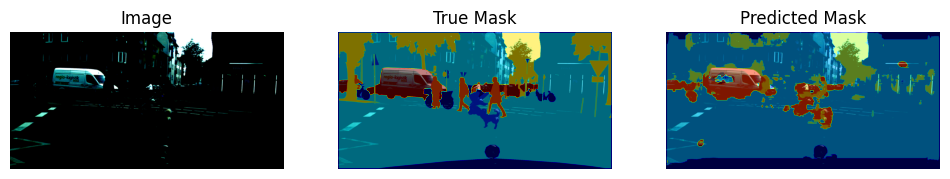

495/495 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.7910 - dice_coefficient: 0.6900 - iou: 0.5284 - loss: 0.6558 - val_accuracy: 0.7700 - val_dice_coefficient: 0.6416 - val_iou: 0.4736 - val_loss: 0.7197 - learning_rate: 1.0000e-04
Epoch 72/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7911 - dice_coefficient: 0.6899 - iou: 0.5282 - loss: 0.6569
Epoch 72: val_loss did not improve from 0.71294
495/495 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.7911 - dice_coefficient: 0.6900 - iou: 0.5283 - loss: 0.6568 - val_accuracy: 0.7710 - val_dice_coefficient: 0.6417 - val_iou: 0.4739 - val_loss: 0.7229 - learning_rate: 1.0000e-04
Epoch 73/250
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.7925 - dice_coefficient: 0.6918 - iou: 0.5304 - loss: 0.6516
Epoch 73: val_loss did not improve from 0.71294
495/495 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.7925 - dice_coefficient: 0.6918 - iou: 0.5304 - loss: 0.6515 - val_accuracy: 0.7708 - val_dice_coefficient: 0.6372

In [ ]:
# Train the model
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=250,
                    callbacks=callbacks)

### 4.3. Save the model and history

In [ ]:
model.save('my_model.keras')

In [ ]:
# Assuming `history` is the object returned by `model.fit()`
with open('trainHistoryDict.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# 3. SegFormer model

## (1) Define paths

In [ ]:
model_name = f'segformer'
# Logs for mlflow
drive_mlflow_logs = f"/content/drive/MyDrive/oc/8th_project/experiments/{model_name}/mlruns"
local_mlflow_logs =f"/content/mlruns"

# Logs for Tensorflow Tensorboard
drive_tbrd_logs = f"/content/drive/MyDrive/oc/8th_project/experiments/{model_name}/tbrd_logs/fit"
local_tbrd_logs = f"/content/tbr_logs/fit"

# checkpoints
drive_ckpts_logs = f"/content/drive/MyDrive/oc/8th_project/experiments/{model_name}/checkpoints"
local_ckpts_logs = f"/content/local_checkpoints"

# model logging
model_logs = f"experiments/segformer/models"

# datasets
drive_train_dataset = f"/content/drive/MyDrive/oc/8th_project/data/train_data"
drive_valid_dataset = f"/content/drive/MyDrive/oc/8th_project/data/valid_data"

# Create the drive directories if it they don't exist
os.makedirs(drive_mlflow_logs, exist_ok=True)
os.makedirs(drive_tbrd_logs, exist_ok=True)
os.makedirs(drive_ckpts_logs, exist_ok=True)
os.makedirs(model_logs, exist_ok=True)
os.makedirs(local_mlflow_logs, exist_ok=True)
os.makedirs(local_tbrd_logs, exist_ok=True)
os.makedirs(local_ckpts_logs, exist_ok=True)

# datasets
drive_train_dataset = f"/content/drive/MyDrive/oc/8th_project/train_data"
drive_valid_dataset = f"/content/drive/MyDrive/oc/8th_project/valid_data"

# local directory for datasets
local_datasets = f"/content/local_datasets"
os.makedirs(local_datasets, exist_ok=True)

## (2) Prepare and load the data for SegFormer

In [ ]:
def resize_images(image, label):

    image = tf.image.resize(image, size=[512, 1024], method=tf.image.ResizeMethod.BILINEAR)

    label = tf.image.resize(label, size=[128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.image.convert_image_dtype(label, tf.uint8)

    output_image = tf.transpose(image, perm=[2, 0, 1])
    output_mask = tf.transpose(label, perm=[2, 0, 1])

    image = tf.image.convert_image_dtype(image, tf.float32)
    output_image = tf.clip_by_value(output_image, clip_value_min=0.0, clip_value_max=1.0)
    return output_image, output_mask



def load_dataset_segf(tfrecord_file, batch_size=2):

    # Create a dataset from the TFRecord file
    dataset = tf.data.TFRecordDataset(tfrecord_file)

    # Parse the serialized examples
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # dataset = dataset.map(lambda x, y: tf.py_function(augment, [x, y], [tf.float32, tf.uint8]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(augment_image_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(resize_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
train_tfrecord_file = "/content/local_datasets/train_images_and_labels_v3.tfrecord"
valid_tfrecord_file = "/content/local_datasets/valid_images_and_labels_v3.tfrecord"
# train_tfrecord_file = "/content/drive/MyDrive/oc/8th_project/data/train/train_images_and_labels_v3.tfrecord"
# valid_tfrecord_file = "/content/drive/MyDrive/oc/8th_project/data/valid/valid_images_and_labels_v3.tfrecord"
train_dataset = load_dataset_segf(train_tfrecord_file, batch_size=16)
valid_dataset = load_dataset_segf(valid_tfrecord_file, batch_size=2)

In [ ]:
def plot_image_segf(image, segmentation, image_title='Original Image'):
    # Convert the image to uint8 if it's not already
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.transpose(image, perm=[1, 2, 0])
    image = tf.image.resize(image, size=[128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Ensure image is in the range [0, 1] and convert to uint8
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
    image = np.array(image)
    image = (image * 255).astype(np.uint8)

    # Convert image to RGB if it's in BGR
    if image.shape[-1] == 3:
        image = image[..., ::-1]  # Convert BGR to RGB if needed

    # Convert segmentation to uint8
    segmentation = tf.transpose(segmentation, perm=[1, 2, 0])
    segmentation = np.array(segmentation)
    # segmentation = (segmentation * 255).astype(np.uint8)

    # Convert to PIL Image
    image = Image.fromarray(image)

    # Plotting the image and its segmentation
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title(image_title)
    axes[0].axis('off')

    # Segmentation mask
    axes[1].imshow(image)
    axes[1].imshow(segmentation, cmap='jet', alpha=0.5)  # Overlaying segmentation with some transparency
    axes[1].set_title('Segmentation Applied')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

(16, 3, 512, 1024)
(16, 1, 128, 256)
1.0
0.0


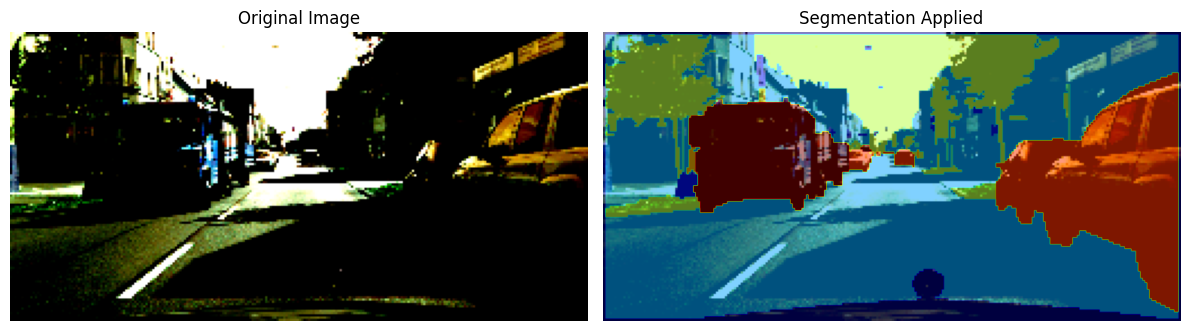

In [ ]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)
    print(images.numpy().max())
    print(images.numpy().min())

    plot_image_segf(images[0], labels[0])

## (3) Prepare Custom Callbacks, Metrics, Logging, Optimizer, and Loss Functions

### 3.1. Plotting functions

#### plot predictions

In [ ]:
def plot_predictions(image, mask, predictions, epoch):
    # Convert predictions to class labels
    predictions = tf.transpose(predictions, perm=[1, 2, 0])
    prediction = tf.argmax(predictions, axis=-1)

    image = tf.transpose(image, perm=[1, 2, 0])
    mask = tf.transpose(mask, perm=[1, 2, 0])

    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].imshow(image)
    axes[0].set_title(f'Epoch {epoch} - Input Image')
    axes[0].axis('off')


    # Segmentation mask
    axes[1].imshow(image)
    axes[1].imshow(mask, cmap='jet', alpha=0.5)  # Overlaying segmentation with some transparency
    axes[1].set_title('True Mask')
    axes[1].axis('off')

    # Segmentation mask
    axes[2].imshow(image)
    axes[2].imshow(prediction, cmap='jet', alpha=0.5)  # Overlaying segmentation with some transparency
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')


    plt.tight_layout()
    plt.savefig(f'predictions_epoch_{epoch}.png')
    plt.show()

#### Plot history function

In [ ]:
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.plot(history['dice_coefficient'])
    plt.plot(history['val_dice_coefficient'])
    plt.plot(history['iou'])
    plt.plot(history['val_iou'])
    plt.title('Model metrics')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Train Acc', 'Val Acc', 'Train Dice', 'Val Dice', 'Train IoU', 'Val IoU'], loc='upper left')

    plt.tight_layout()
    plt.show()

### 3.2 Prepare Logging

#### 1. Set up mlflow

In [ ]:
mlflow.set_tracking_uri(drive_mlflow_logs)
experiment_name = "segformer"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/content/drive/MyDrive/oc/8th_project/experiments/segformer/mlruns/963968945826779690', creation_time=1724842862216, experiment_id='963968945826779690', last_update_time=1724842862216, lifecycle_stage='active', name='segformer', tags={}>

In [ ]:
# Authenticate ngrok with your authtoken
ngrok.set_auth_token('2gluH2W7INNUrnODbUAMZ9UnOMe_541YvYEvmSe56bcgqv1AH')

In [ ]:
# Start the MLflow UI
get_ipython().system_raw("mlflow ui --backend-store-uri /content/mlruns &")

In [ ]:
public_url = ngrok.connect(addr='5000')

In [ ]:
print(f"MLflow UI is available at: {public_url}")

MLflow UI is available at: NgrokTunnel: "https://bfa7-34-126-94-83.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
# Start MLflow run and enable autologging
mlflow.start_run()
mlflow.tensorflow.autolog()

#### 2. Set up history object

In [ ]:
class CustomHistory(Callback):

    def on_train_begin(self, logs=None):
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'dice_coefficient': [],
            'val_dice_coefficient': [],
            'iou': [],
            'val_iou': []
        }

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history[key].append(value)

In [ ]:
# Instantiate the custom history callback and initialize history
custom_history = CustomHistory()
custom_history.on_train_begin()

#### 3. Set up Tensorboard

In [ ]:
# Define the log directory for TensorBoard
tbrd_log_dir = drive_tbrd_logs + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_writer = tf.summary.create_file_writer(tbrd_log_dir)
print(f"TensorBoard log directory: {tbrd_log_dir}")

TensorBoard log directory: /content/drive/MyDrive/oc/8th_project/experiments/segformer/tbrd_logs/fit20240901-115701


### 3.3. Define Metrics

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_true), 'float32')
    y_pred_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_pred), 'float32')
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, num_classes=8, smooth=1e-6):

    # One-hot encode the true and predicted labels

    y_true_f = tf.one_hot(tf.cast(y_true, tf.uint8), depth=num_classes)

    y_pred = tf.squeeze(y_pred)
    y_pred_f = tf.one_hot(tf.cast(y_pred, tf.uint8), depth=num_classes)

    # Flatten the tensors
    y_true_f = tf.reshape(y_true_f, [-1])
    y_pred_f = tf.reshape(y_pred_f, [-1])

    # Calculate the intersection
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the union
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) - intersection

    # Calculate the IoU
    iou = (intersection + smooth) / (union + smooth)
    return iou

### 3.4. Prepare optimizer and loss functions

In [ ]:
# Optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

# Metrics
train_loss = Mean(name='train_loss')
train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')
val_loss = Mean(name='val_loss')
val_accuracy = SparseCategoricalAccuracy(name='val_accuracy')

## (4) Load/initialize, train, and save [Segformer] model

### 4.1. Load pre trained model

In [ ]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
# Create a new configuration
config = SegformerConfig(
    num_labels=8,  # Set the number of labels/classes
    id2label={0: "flat", 1: "human", 2: "vehicle", 3: "construction", 4: "object", 5: "nature", 6: "sky", 7: "void"},
    label2id={"flat": 0, "human": 1, "vehicle": 2, "construction": 3, "object": 4, "nature": 5, "sky": 6, "void": 7},
    image_size=(512, 1024),  # Specify the input image size
)

In [ ]:
model = TFSegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024",
                                                                config=config,
                                                                ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-512-1024 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 256, 19) in the checkpoint and (1, 1, 256, 8) in the model instantiated
- decode_head/classifier/bias:0: found shape (19,) in the checkpoint and (8,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Define train_step and val_step functions

In [ ]:
@tf.function
def train_step(images, masks):
    with tf.GradientTape() as tape:
        # Get logits from the model
        logits = model(images, training=True).logits

        # Ensure logits have shape [batch_size, height, width, num_classes]
        logits = tf.transpose(logits, perm=[0, 2, 3, 1])

        # Ensure masks shape is correct
        masks = tf.squeeze(masks) #, axis=-1)

        # Compute loss using logits directly
        loss = loss_fn(masks, logits)

    # Compute gradients and apply them
    # scaled_loss = optimizer.get_scaled_loss(loss)
    gradients = tape.gradient(loss, model.trainable_variables)

    # scaled_gradients = optimizer.get_unscaled_gradients(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics with predictions (using argmax to get predicted classes)
    train_loss(loss)
    train_accuracy.update_state(masks, logits)
    return loss

@tf.function
def val_step(images, masks):
    # Get logits from the model
    # with tf.device('/CPU:0'):  # Ensure validation is done on CPU
    logits = model(images, training=False).logits

    # Ensure logits have shape [batch_size, height, width, num_classes]
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])

    # Remove the last dimension of masks if it exists
    masks = tf.squeeze(masks) #, axis=-1)

    # Compute loss
    loss = loss_fn(masks, logits)

    # Update metrics with predictions (using argmax to get predicted classes)
    val_loss(loss)
    val_accuracy.update_state(masks, logits)
    return loss

### 4.3 Training the model

In [ ]:
epochs = 250
best_val_loss = float('inf')
patience = 0
stop_callback = 0

Epoch 1, Loss: 0.8934131264686584, Accuracy: 74.00788116455078, Val Loss: 0.6591393947601318, Val Accuracy: 79.47843170166016, Dice Coefficient: 3.034303903579712, Val Dice Coefficient: 3.119450092315674, IoU: 0.6427919268608093, Val IoU: 0.5839899182319641


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


New best model saved with val loss: 0.6591393947601318
1/1 [==============================] - 4s 4s/step


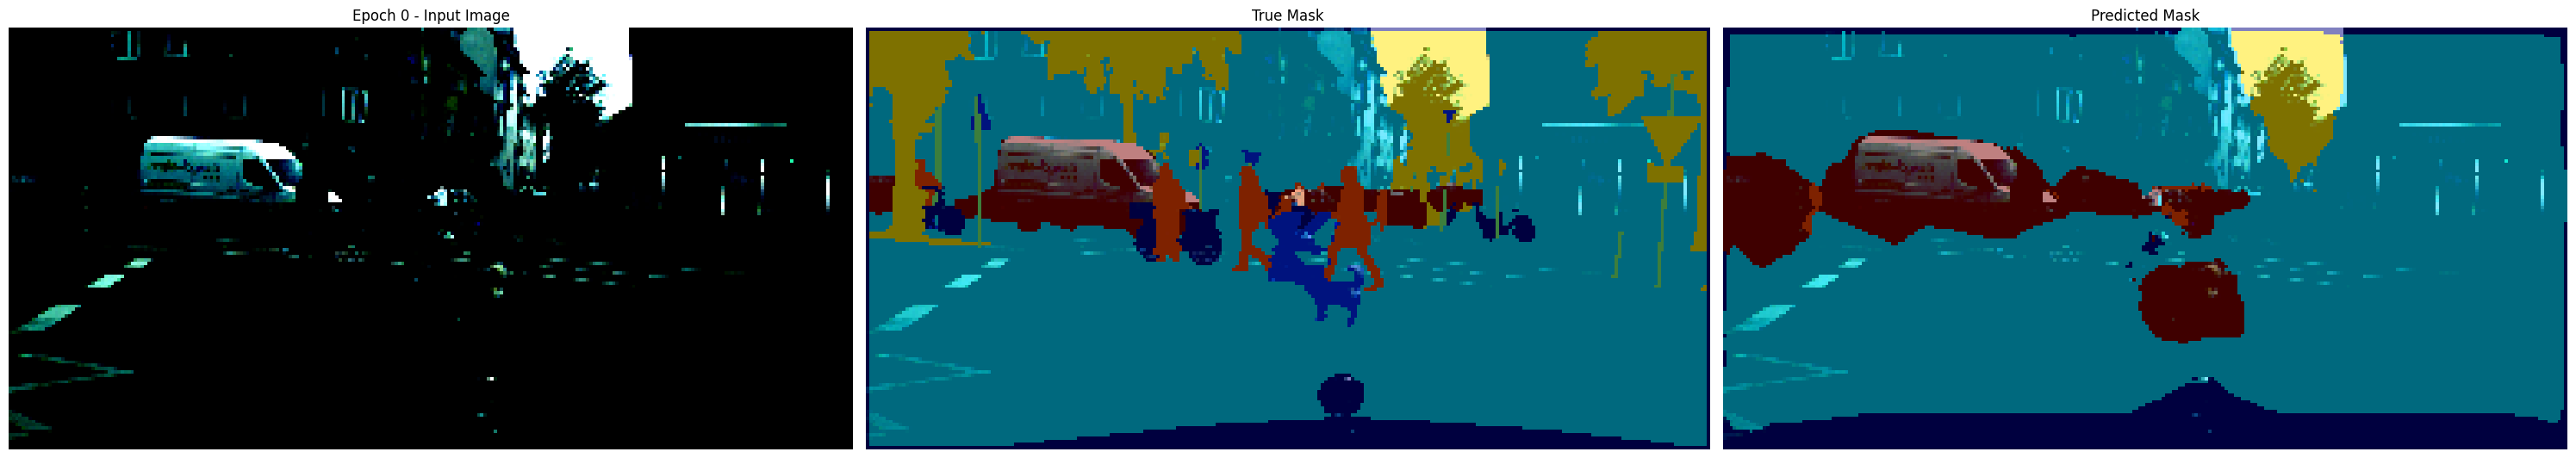

Epoch 2, Loss: 0.6127210259437561, Accuracy: 80.7890625, Val Loss: 0.571742594242096, Val Accuracy: 81.42293548583984, Dice Coefficient: 3.0721991062164307, Val Dice Coefficient: 3.2322065830230713, IoU: 0.6692976355552673, Val IoU: 0.6174938678741455
New best model saved with val loss: 0.571742594242096
Epoch 3, Loss: 0.5515275597572327, Accuracy: 82.34307098388672, Val Loss: 0.5628114938735962, Val Accuracy: 81.7127914428711, Dice Coefficient: 3.1225032806396484, Val Dice Coefficient: 3.2646424770355225, IoU: 0.6924417614936829, Val IoU: 0.623323380947113
New best model saved with val loss: 0.5628114938735962
Epoch 4, Loss: 0.5169742703437805, Accuracy: 83.33074188232422, Val Loss: 0.5385403633117676, Val Accuracy: 82.31977081298828, Dice Coefficient: 3.1038308143615723, Val Dice Coefficient: 3.191570281982422, IoU: 0.6885771155357361, Val IoU: 0.609074592590332
New best model saved with val loss: 0.5385403633117676
Epoch 5, Loss: 0.495174378156662, Accuracy: 83.90875244140625, Val L

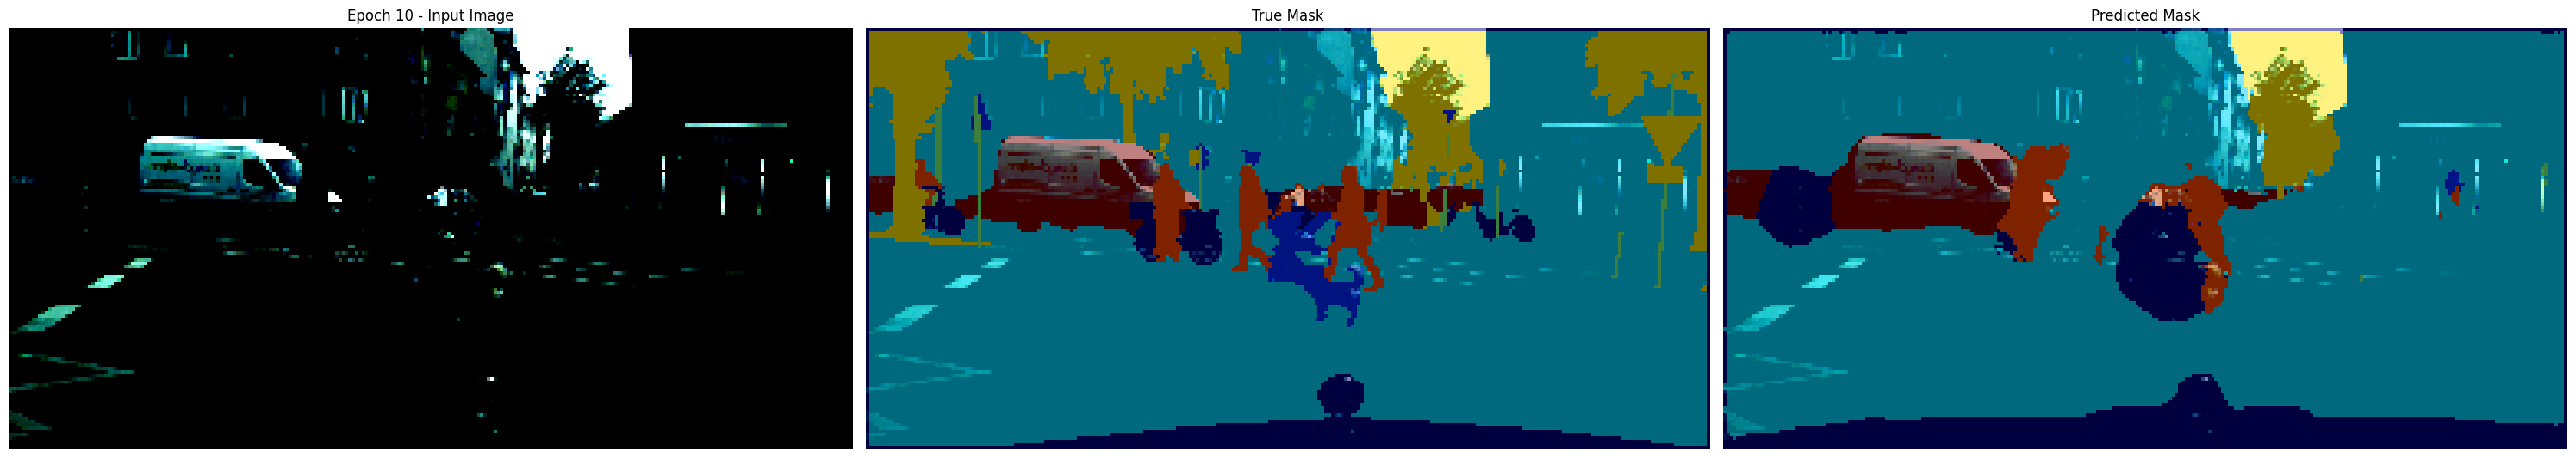

Epoch 12, Loss: 0.4100070893764496, Accuracy: 86.45586395263672, Val Loss: 0.4843600392341614, Val Accuracy: 83.99873352050781, Dice Coefficient: 3.1775758266448975, Val Dice Coefficient: 3.2667510509490967, IoU: 0.7467241883277893, Val IoU: 0.6332552433013916
Epoch 13, Loss: 0.4049421548843384, Accuracy: 86.6000747680664, Val Loss: 0.48585638403892517, Val Accuracy: 83.97791290283203, Dice Coefficient: 3.1396775245666504, Val Dice Coefficient: 3.2031984329223633, IoU: 0.7232739329338074, Val IoU: 0.6202130913734436
Epoch 14, Loss: 0.4015792906284332, Accuracy: 86.70205688476562, Val Loss: 0.4826231598854065, Val Accuracy: 84.12976837158203, Dice Coefficient: 3.179544448852539, Val Dice Coefficient: 3.2708120346069336, IoU: 0.7444140315055847, Val IoU: 0.6395887136459351
New best model saved with val loss: 0.4826231598854065
Epoch 15, Loss: 0.39761850237846375, Accuracy: 86.78851318359375, Val Loss: 0.4803466200828552, Val Accuracy: 84.13558959960938, Dice Coefficient: 3.18871092796325

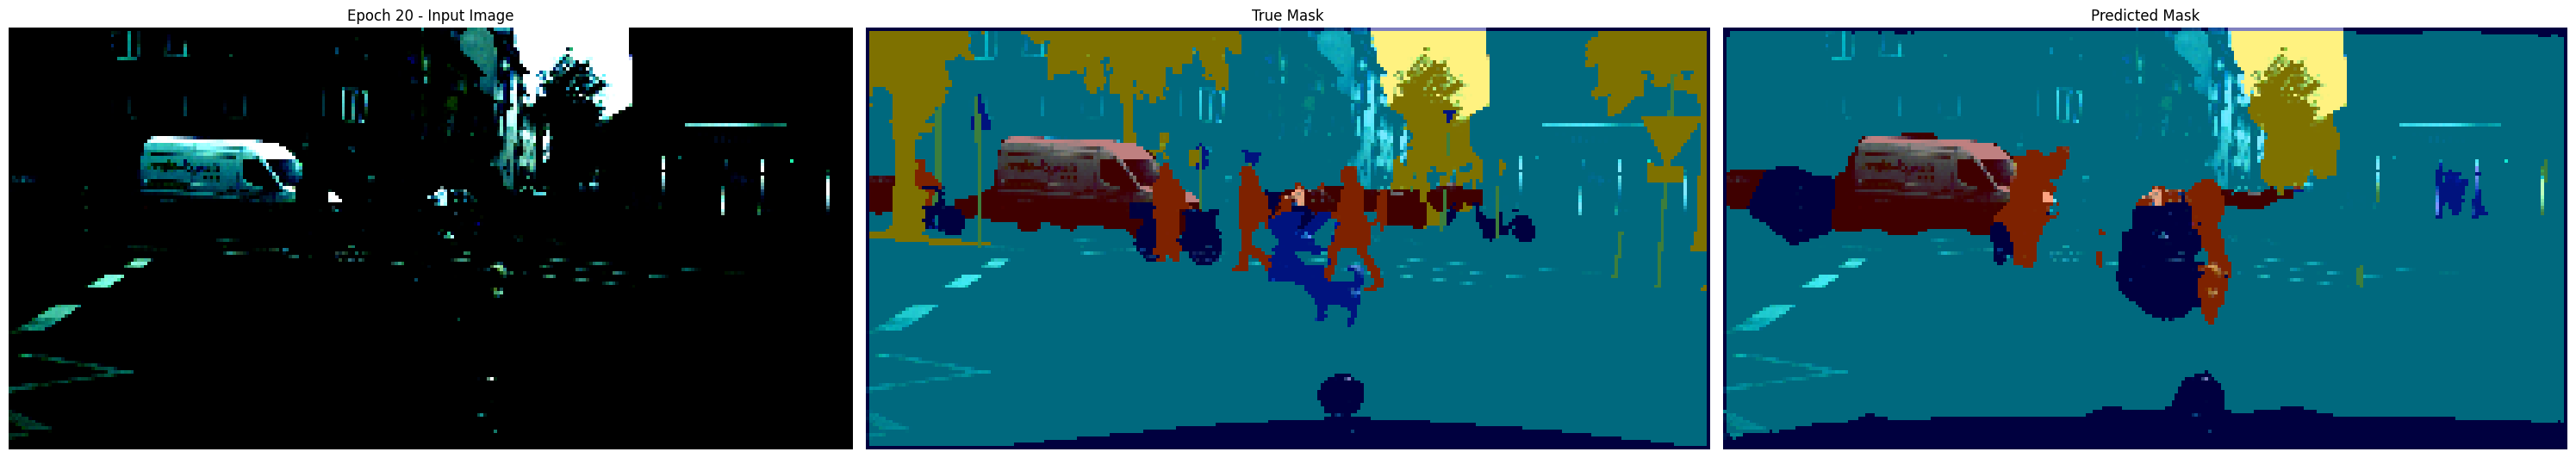

Epoch 22, Loss: 0.35964760184288025, Accuracy: 87.89090728759766, Val Loss: 0.47163552045822144, Val Accuracy: 84.54000091552734, Dice Coefficient: 3.200542688369751, Val Dice Coefficient: 3.2832319736480713, IoU: 0.7756974697113037, Val IoU: 0.6496796607971191
Epoch 23, Loss: 0.3572738766670227, Accuracy: 88.03407287597656, Val Loss: 0.47998693585395813, Val Accuracy: 84.5927505493164, Dice Coefficient: 3.2021257877349854, Val Dice Coefficient: 3.286206007003784, IoU: 0.7744864821434021, Val IoU: 0.6489118337631226
Epoch 24, Loss: 0.3545897603034973, Accuracy: 88.10820007324219, Val Loss: 0.47732603549957275, Val Accuracy: 84.58712768554688, Dice Coefficient: 3.2136998176574707, Val Dice Coefficient: 3.2750113010406494, IoU: 0.7784531712532043, Val IoU: 0.6514464020729065
Epoch 25, Loss: 0.3505641520023346, Accuracy: 88.21769714355469, Val Loss: 0.48211315274238586, Val Accuracy: 84.42105102539062, Dice Coefficient: 3.201741933822632, Val Dice Coefficient: 3.2547457218170166, IoU: 0.7

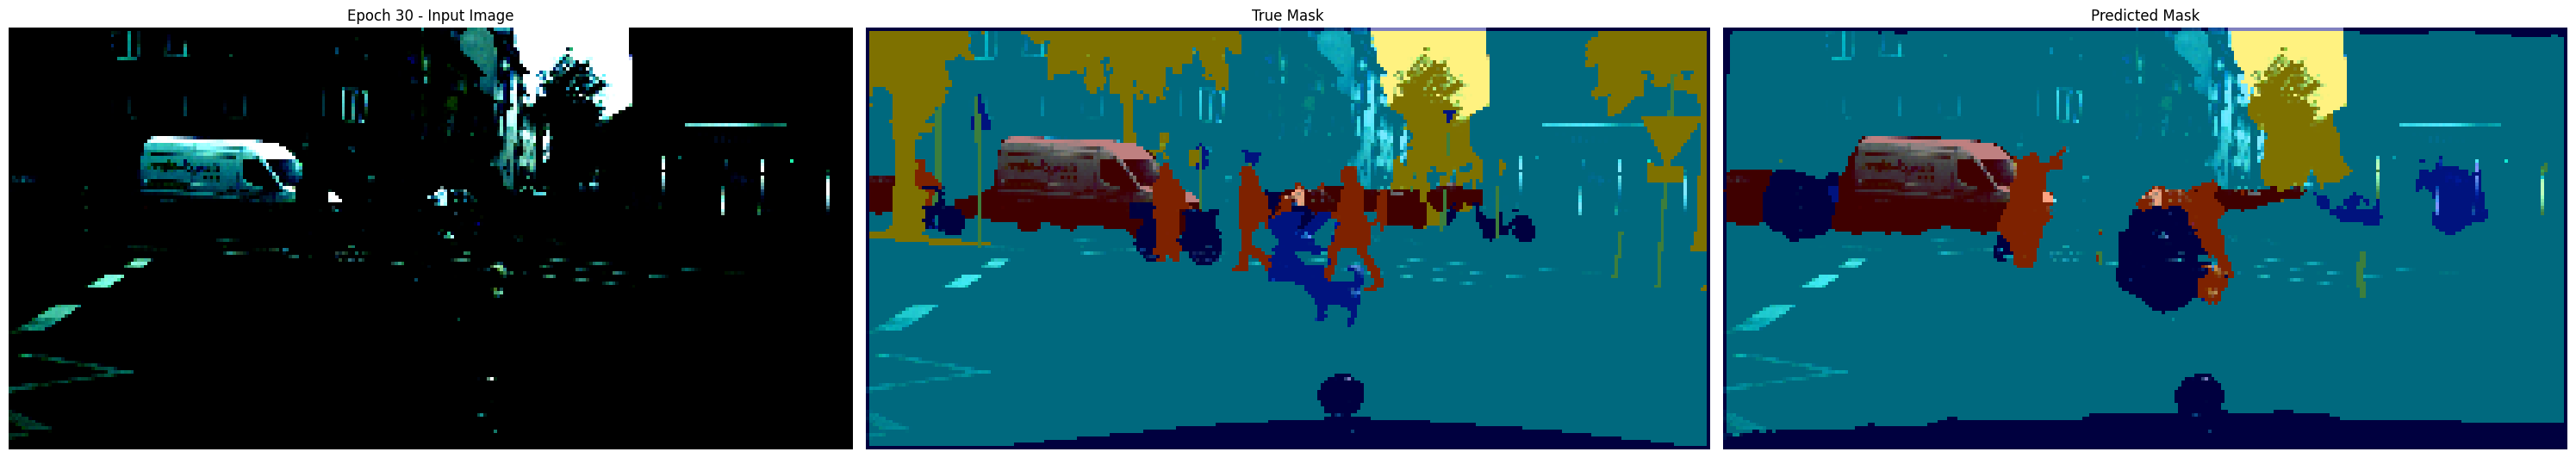

Epoch 32, Loss: 0.3284726142883301, Accuracy: 88.86056518554688, Val Loss: 0.4594068229198456, Val Accuracy: 85.04364776611328, Dice Coefficient: 3.1972196102142334, Val Dice Coefficient: 3.278623104095459, IoU: 0.79244065284729, Val IoU: 0.6566019058227539
Epoch 33, Loss: 0.32812628149986267, Accuracy: 88.92877960205078, Val Loss: 0.46174341440200806, Val Accuracy: 85.1505126953125, Dice Coefficient: 3.1994638442993164, Val Dice Coefficient: 3.286919593811035, IoU: 0.7750091552734375, Val IoU: 0.6503235697746277
Epoch 34, Loss: 0.32508584856987, Accuracy: 89.01432037353516, Val Loss: 0.45391756296157837, Val Accuracy: 85.25807189941406, Dice Coefficient: 3.2161171436309814, Val Dice Coefficient: 3.2767393589019775, IoU: 0.7949474453926086, Val IoU: 0.6376425623893738
New best model saved with val loss: 0.45391756296157837
Epoch 35, Loss: 0.32000207901000977, Accuracy: 89.14027404785156, Val Loss: 0.4574297368526459, Val Accuracy: 85.26366424560547, Dice Coefficient: 3.213512659072876,

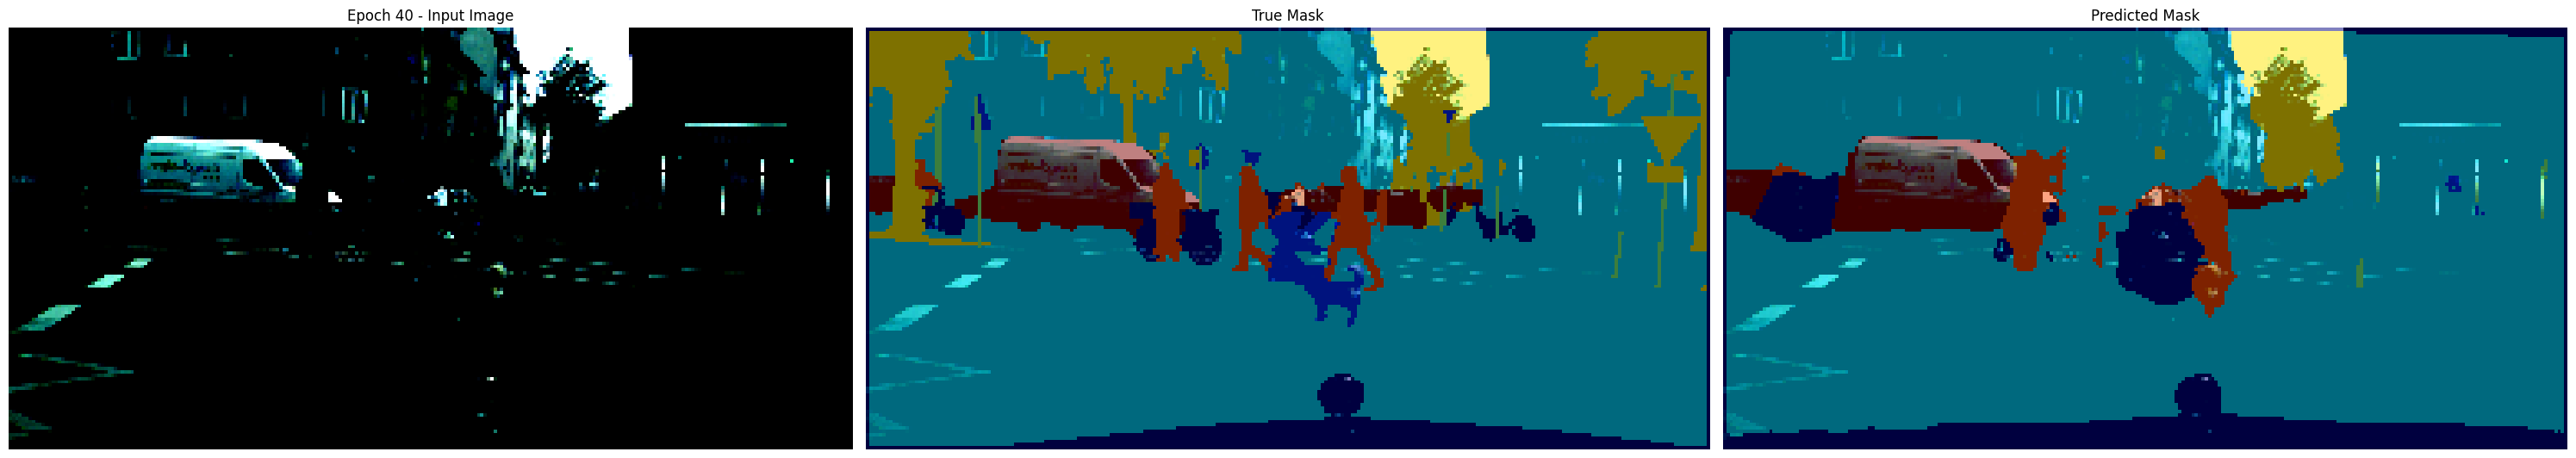

Epoch 42, Loss: 0.3050670325756073, Accuracy: 89.62657165527344, Val Loss: 0.4537540078163147, Val Accuracy: 85.37239074707031, Dice Coefficient: 3.231332778930664, Val Dice Coefficient: 3.2924325466156006, IoU: 0.8088158965110779, Val IoU: 0.6400811076164246
Epoch 43, Loss: 0.3043130934238434, Accuracy: 89.6728744506836, Val Loss: 0.4522770643234253, Val Accuracy: 85.45051574707031, Dice Coefficient: 3.2130279541015625, Val Dice Coefficient: 3.261214256286621, IoU: 0.8062888979911804, Val IoU: 0.659349262714386
Epoch 44, Loss: 0.3024931848049164, Accuracy: 89.70332336425781, Val Loss: 0.4497186839580536, Val Accuracy: 85.60993194580078, Dice Coefficient: 3.238084316253662, Val Dice Coefficient: 3.262809991836548, IoU: 0.8082668781280518, Val IoU: 0.6573560237884521
Epoch 45, Loss: 0.29975205659866333, Accuracy: 89.85993957519531, Val Loss: 0.4538775682449341, Val Accuracy: 85.51307678222656, Dice Coefficient: 3.2384114265441895, Val Dice Coefficient: 3.2724123001098633, IoU: 0.8191843

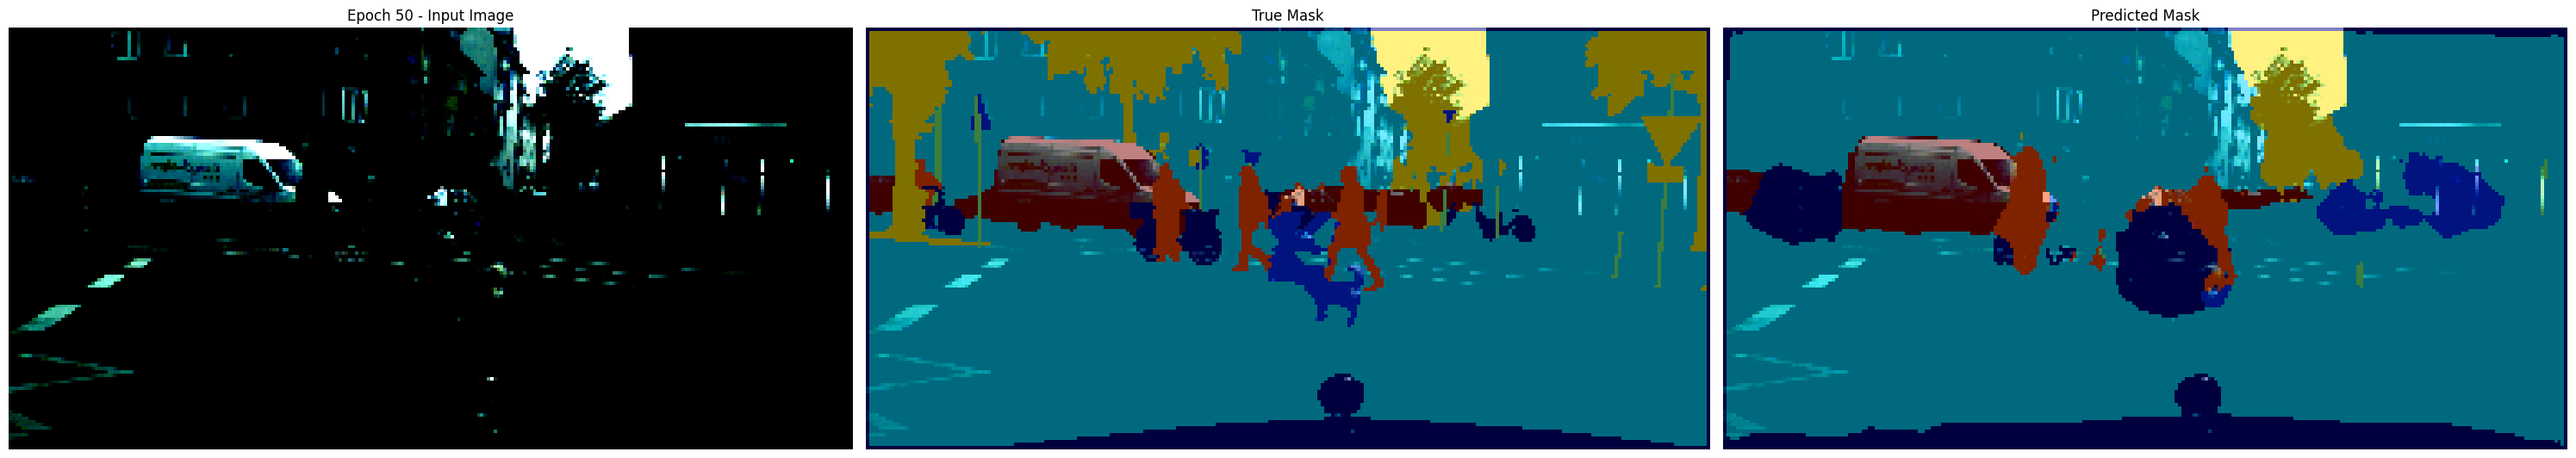

Epoch 52, Loss: 0.2861001491546631, Accuracy: 90.20905303955078, Val Loss: 0.450771301984787, Val Accuracy: 85.90003967285156, Dice Coefficient: 3.190911054611206, Val Dice Coefficient: 3.2660903930664062, IoU: 0.7928544282913208, Val IoU: 0.643123984336853
Reduced learning rate to 4.999999873689376e-05
Epoch 53, Loss: 0.2821126878261566, Accuracy: 90.36149597167969, Val Loss: 0.4416780471801758, Val Accuracy: 86.21707916259766, Dice Coefficient: 3.2382307052612305, Val Dice Coefficient: 3.2472331523895264, IoU: 0.8239942789077759, Val IoU: 0.6459094882011414
New best model saved with val loss: 0.4416780471801758
Epoch 54, Loss: 0.28263890743255615, Accuracy: 90.34154510498047, Val Loss: 0.44644075632095337, Val Accuracy: 86.13661193847656, Dice Coefficient: 3.2047195434570312, Val Dice Coefficient: 3.254497766494751, IoU: 0.8009930849075317, Val IoU: 0.6413955688476562
Epoch 55, Loss: 0.2794148027896881, Accuracy: 90.43370819091797, Val Loss: 0.4491744339466095, Val Accuracy: 86.12642

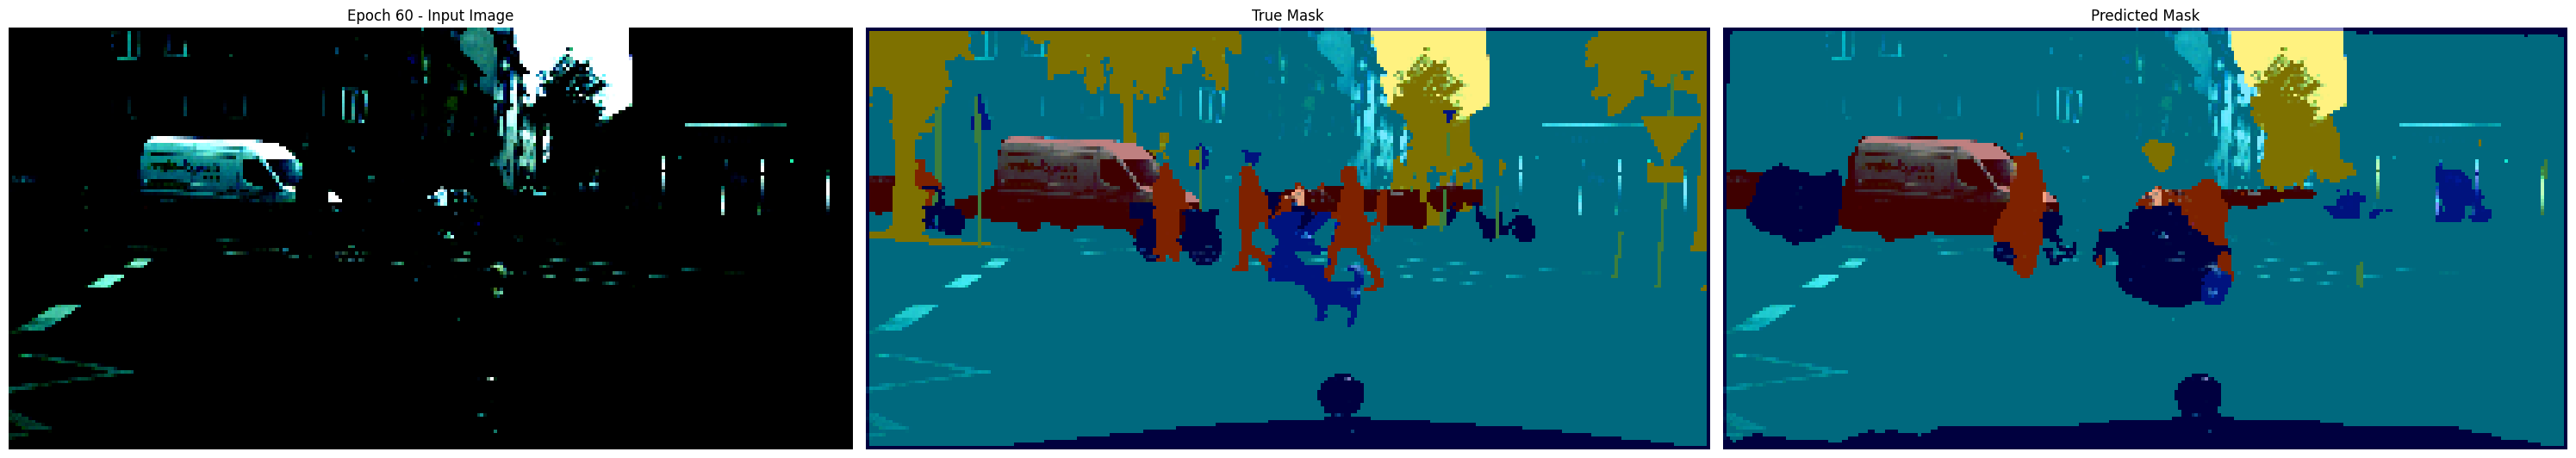

Epoch 62, Loss: 0.2699522376060486, Accuracy: 90.76262664794922, Val Loss: 0.45196303725242615, Val Accuracy: 86.5058364868164, Dice Coefficient: 3.223388910293579, Val Dice Coefficient: 3.2640857696533203, IoU: 0.8258745074272156, Val IoU: 0.6580478549003601
Epoch 63, Loss: 0.2697037160396576, Accuracy: 90.76095581054688, Val Loss: 0.4487360715866089, Val Accuracy: 86.52857208251953, Dice Coefficient: 3.2179436683654785, Val Dice Coefficient: 3.254503011703491, IoU: 0.8243528604507446, Val IoU: 0.655430257320404
Epoch 64, Loss: 0.26881852746009827, Accuracy: 90.77751922607422, Val Loss: 0.463289737701416, Val Accuracy: 86.1734619140625, Dice Coefficient: 3.2241709232330322, Val Dice Coefficient: 3.2609424591064453, IoU: 0.8227291703224182, Val IoU: 0.6520292162895203
Reduced learning rate to 2.499999936844688e-05
Epoch 65, Loss: 0.26605895161628723, Accuracy: 90.85308837890625, Val Loss: 0.45284223556518555, Val Accuracy: 86.44759368896484, Dice Coefficient: 3.2326467037200928, Val Di

In [ ]:
# Custom training loop

for epoch in range(epochs):

    # Reset custom metrics at the start of each epoch
    
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

    # Training loop
    for images, masks in train_dataset:
        train_step(images, masks)

    # Validation loop
    for val_images, val_masks in valid_dataset:
        val_step(val_images, val_masks)


    # Compute, save and print all metrics at the end of each epoch

    # Compute custom metrics

    ## Metrics on training data
    logits = model(images).logits
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    logits = tf.argmax(logits, axis=-1, output_type=tf.int32)

    ## Metrics on validation data
    val_logits = model(val_images).logits
    val_logits = tf.transpose(val_logits, perm=[0, 2, 3, 1])
    val_logits = tf.argmax(val_logits, axis=-1, output_type=tf.int32)

    dice_coef = dice_coefficient(masks, logits).numpy() # changed recently
    val_dice_coef = dice_coefficient(val_masks, val_logits).numpy()

    iou_metric = iou(masks, logits).numpy() # changed recently
    val_iou_metric = iou(val_masks, val_logits).numpy()

    # Log metrics to the custom history
    custom_history.on_epoch_end(epoch, logs={
        'loss': train_loss.result().numpy(),
        'accuracy': train_accuracy.result().numpy(),
        'val_loss': val_loss.result().numpy(),
        'val_accuracy': val_accuracy.result().numpy(),
        'dice_coefficient': dice_coef,
        'val_dice_coefficient': val_dice_coef,
        'iou': iou_metric,
        'val_iou': val_iou_metric
    })

    # Print current epoch metrics
    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}, '
          f'Val Loss: {val_loss.result()}, '
          f'Val Accuracy: {val_accuracy.result() * 100}, '
          f'Dice Coefficient: {dice_coef}, '
          f'Val Dice Coefficient: {val_dice_coef}, '
          f'IoU: {iou_metric}, '
          f'Val IoU: {val_iou_metric}')

    ### 2. Log metrics to MLflow
    mlflow.log_metric('train_loss', train_loss.result().numpy(), step=epoch)
    mlflow.log_metric('train_accuracy', train_accuracy.result().numpy(), step=epoch)
    mlflow.log_metric('val_loss', val_loss.result().numpy(), step=epoch)
    mlflow.log_metric('val_accuracy', val_accuracy.result().numpy(), step=epoch)
    mlflow.log_metric('dice_coefficient', dice_coef, step=epoch)
    mlflow.log_metric('val_dice_coefficient', val_dice_coef, step=epoch)
    mlflow.log_metric('iou', iou_metric, step=epoch)
    mlflow.log_metric('val_iou', val_iou_metric, step=epoch)

    ### 3. Log metrics to Tensorboard
    with tensorboard_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('train_accuracy', train_accuracy.result(), step=epoch)
        tf.summary.scalar('val_loss', val_loss.result(), step=epoch)
        tf.summary.scalar('val_accuracy', val_accuracy.result(), step=epoch)
        tf.summary.scalar('dice_coefficient', dice_coef, step=epoch)
        tf.summary.scalar('val_dice_coefficient', val_dice_coef, step=epoch)
        tf.summary.scalar('iou', iou_metric, step=epoch)
        tf.summary.scalar('val_iou', val_iou_metric, step=epoch)


    # Callback (1) - check for the best model and save at the checkpoint
    if val_loss.result() < best_val_loss:
        patience = 0
        stop_callback = 0
        best_val_loss = val_loss.result()

        model_path = f"{model_logs}/best_model_epoch_{epoch + 1}_{val_loss.result()}.keras"
        model.save(model_path)  # Save entire model in .keras format
        print(f'New best model saved with val loss: {best_val_loss}')
    else:
        patience += 1
        stop_callback += 1

    # Callback (2) - plot and save predictions
    if epoch % 10 == 0:
        for val_images, val_masks in valid_dataset.take(1):
            predictions = model.predict(val_images)
            plot_predictions(val_images[0].numpy(), val_masks[0], predictions.logits[0], epoch)
            # mlflow.log_artifact(f'{drive_mlflow_logs}/')

    # CALLBACK (3) - reduce learning rate on plateau
    if (patience > 10) and (val_loss.result() > best_val_loss):
        patience = 0
        new_lr = optimizer.learning_rate.numpy() * 0.5
        if new_lr >= 1e-6:
            optimizer.learning_rate.assign(new_lr)
            print(f'Reduced learning rate to {new_lr}')

    # CALLBACK (4) - check if early stopping condition is met
    if stop_callback > 15:
        print('Early stopping triggered')
        break
    gc.collect()